In [163]:
import numpy as np
import pandas as pd, tslib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats
import tempfile
import logging
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from pandas import Timestamp

%matplotlib inline

Loading BokehJS ...

In [2]:
#reading in CSV's from a file path
dataf = pd.read_csv('C:\\Users\\LeonFremz\\Modelling and Optimisation\\Womens Clothing E-Commerce Reviews.csv')

In [3]:
datafText = dataf['Review Text']
datafText.index = dataf['Title'] #This is to publish the dates of the dataset in a way that can be parsed properly for further analysis like timeseries

In [4]:
dataf['Review Text'].head()

Title
NaN                        Absolutely wonderful - silky and sexy and comf...
NaN                        Love this dress!  it's sooo pretty.  i happene...
Some major design flaws    I had such high hopes for this dress and reall...
My favorite buy!           I love, love, love this jumpsuit. it's fun, fl...
Flattering shirt           This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [5]:
datafText.sample(10)#Random sample of the dataset (10)

Title
Your new favorite pair of jeans                       The nolan's are my favorite pair of jeans from...
Cute itsy socks                                       Love polkadots, love sparkle. these little soc...
My favorite pants i have ever bought from retailer    These pants are a life saver. i love to travel...
Ski lodge turtleneck                                  Cozy slouchy sweater. very versatile. fits tts...
Love                                                  I ordered this dress to wear to a mid summer e...
Cute top                                              I like the top; like the tie in the front. the...
Cheaply made but flattering cut                       This is the perfect peplum. it floats a bit bu...
NaN                                                   I wanted to love this dress. it really has no ...
Lovely color                                          Lovely color and sweet top, but the fabric was...
Just okay                                             The 

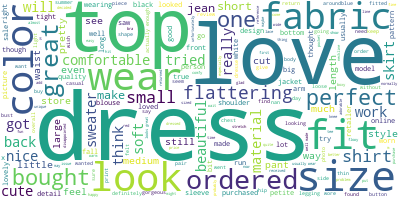

In [6]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(dataf['Review Text'].values.astype(str)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [7]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_title = count_vectorizer.fit_transform(text_data.values.astype(str))
    vec_total = np.sum(vec_title, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_title.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])
    
    
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=datafText)

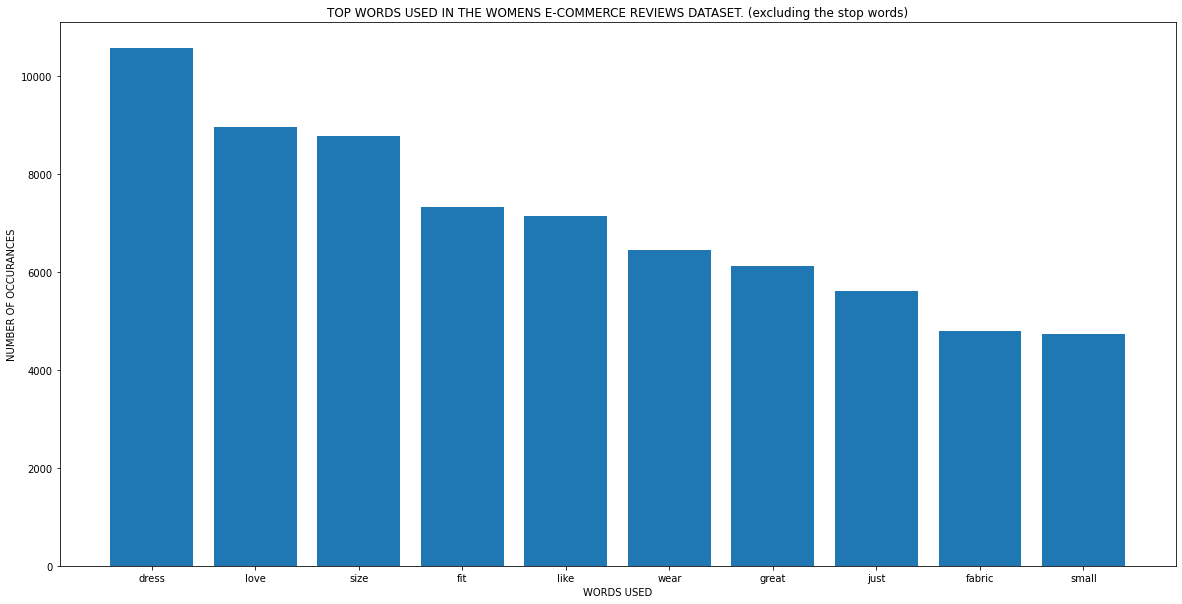

In [8]:

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE WOMENS E-COMMERCE REVIEWS DATASET. (excluding the stop words)');
ax.set_xlabel('WORDS USED');
ax.set_ylabel('NUMBER OF OCCURANCES');
plt.show()

In [9]:

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=10)
#small_text_sample = datafText.sample(n=123, random_state=0).values
small_text_sample = datafText.values.astype(str)
print('REVIEW BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('REVIEW AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

REVIEW BEFORE VECTORIZATION: After reading the previous reviews, i ordered a size larger. i am so glad i did it! it fits perfectly! i am 5'4"/115/32dd and went with the s regular. so beautiful! i can't wait to wear it!
REVIEW AFTER VECTORIZATION: 
  (0, 7)	1
  (0, 9)	1


In [10]:
numberOfTopics = 9

In [11]:
#Latent Semantic Analysis

In [24]:
lSAModel = TruncatedSVD(n_components=numberOfTopics)
lSATopicMatrix = lSAModel.fit_transform(small_document_term_matrix)

In [22]:
def collectLSAtopics(LDAModel, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    featureNames = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(numberOfTopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        wordsIDs = lSAModel.components_[i].argsort()[:-20 - 1:-1]
        words = [ featureNames[key] for key in wordsIDs]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [23]:
collectLSAtopics(lSAModel, 30)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,dress,dress,size,like,fit,wear,great,just,small
1,size,fabric,small,just,great,small,like,fabric,great
2,love,just,fit,fabric,wear,great,size,great,love
3,fit,wear,dress,fit,small,fabric,fabric,size,dress
4,like,great,like,wear,just,dress,dress,dress,like
5,wear,small,fabric,small,fabric,size,love,love,fabric
6,just,like,just,great,dress,just,just,wear,just
7,great,fit,wear,dress,size,like,wear,small,size
8,small,love,great,size,love,love,small,like,fit
9,fabric,size,love,love,like,fit,fit,fit,wear


In [16]:
# Defining the helper functions
###########Edit################
def collectKeys(topicMatrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topicMatrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [25]:
LSAkeys = collectKeys(lSATopicMatrix )
LSAcategories, lsa_counts = keys_to_counts(LSAkeys)

In [94]:

# Defining the helper functions
#########################Edit#############################
def collectTopnWords(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    indicesOfTop_Word = []
    for topic in range(numberOfTopics):
        tempVectorSum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                tempVectorSum += document_term_matrix[i]
        tempVectorSum = tempVectorSum.toarray()
        top_n_word_indices = np.flip(np.argsort(tempVectorSum)[0][-n:],0)
        indicesOfTop_Word.append(top_n_word_indices)   
    top_words = []
    for topic in indicesOfTop_Word:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [29]:
top_n_words_lsa = collectTopnWords(15, LSAkeys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])
    

Topic 1:  dress love size fit like wear fabric just great small
Topic 2:  dress fabric wear great just small like fit size love
Topic 3:  size fit small fabric like wear just dress great love
Topic 4:  like fabric fit just wear great small love size dress
Topic 5:  fit great wear small fabric just love size dress like
Topic 6:  wear small love great size fabric just like dress fit
Topic 7:  great love size like fabric dress wear just fit small
Topic 8:  just love fabric size great fit wear like dress small
Topic 9:  small size love great like fabric just fit dress wear


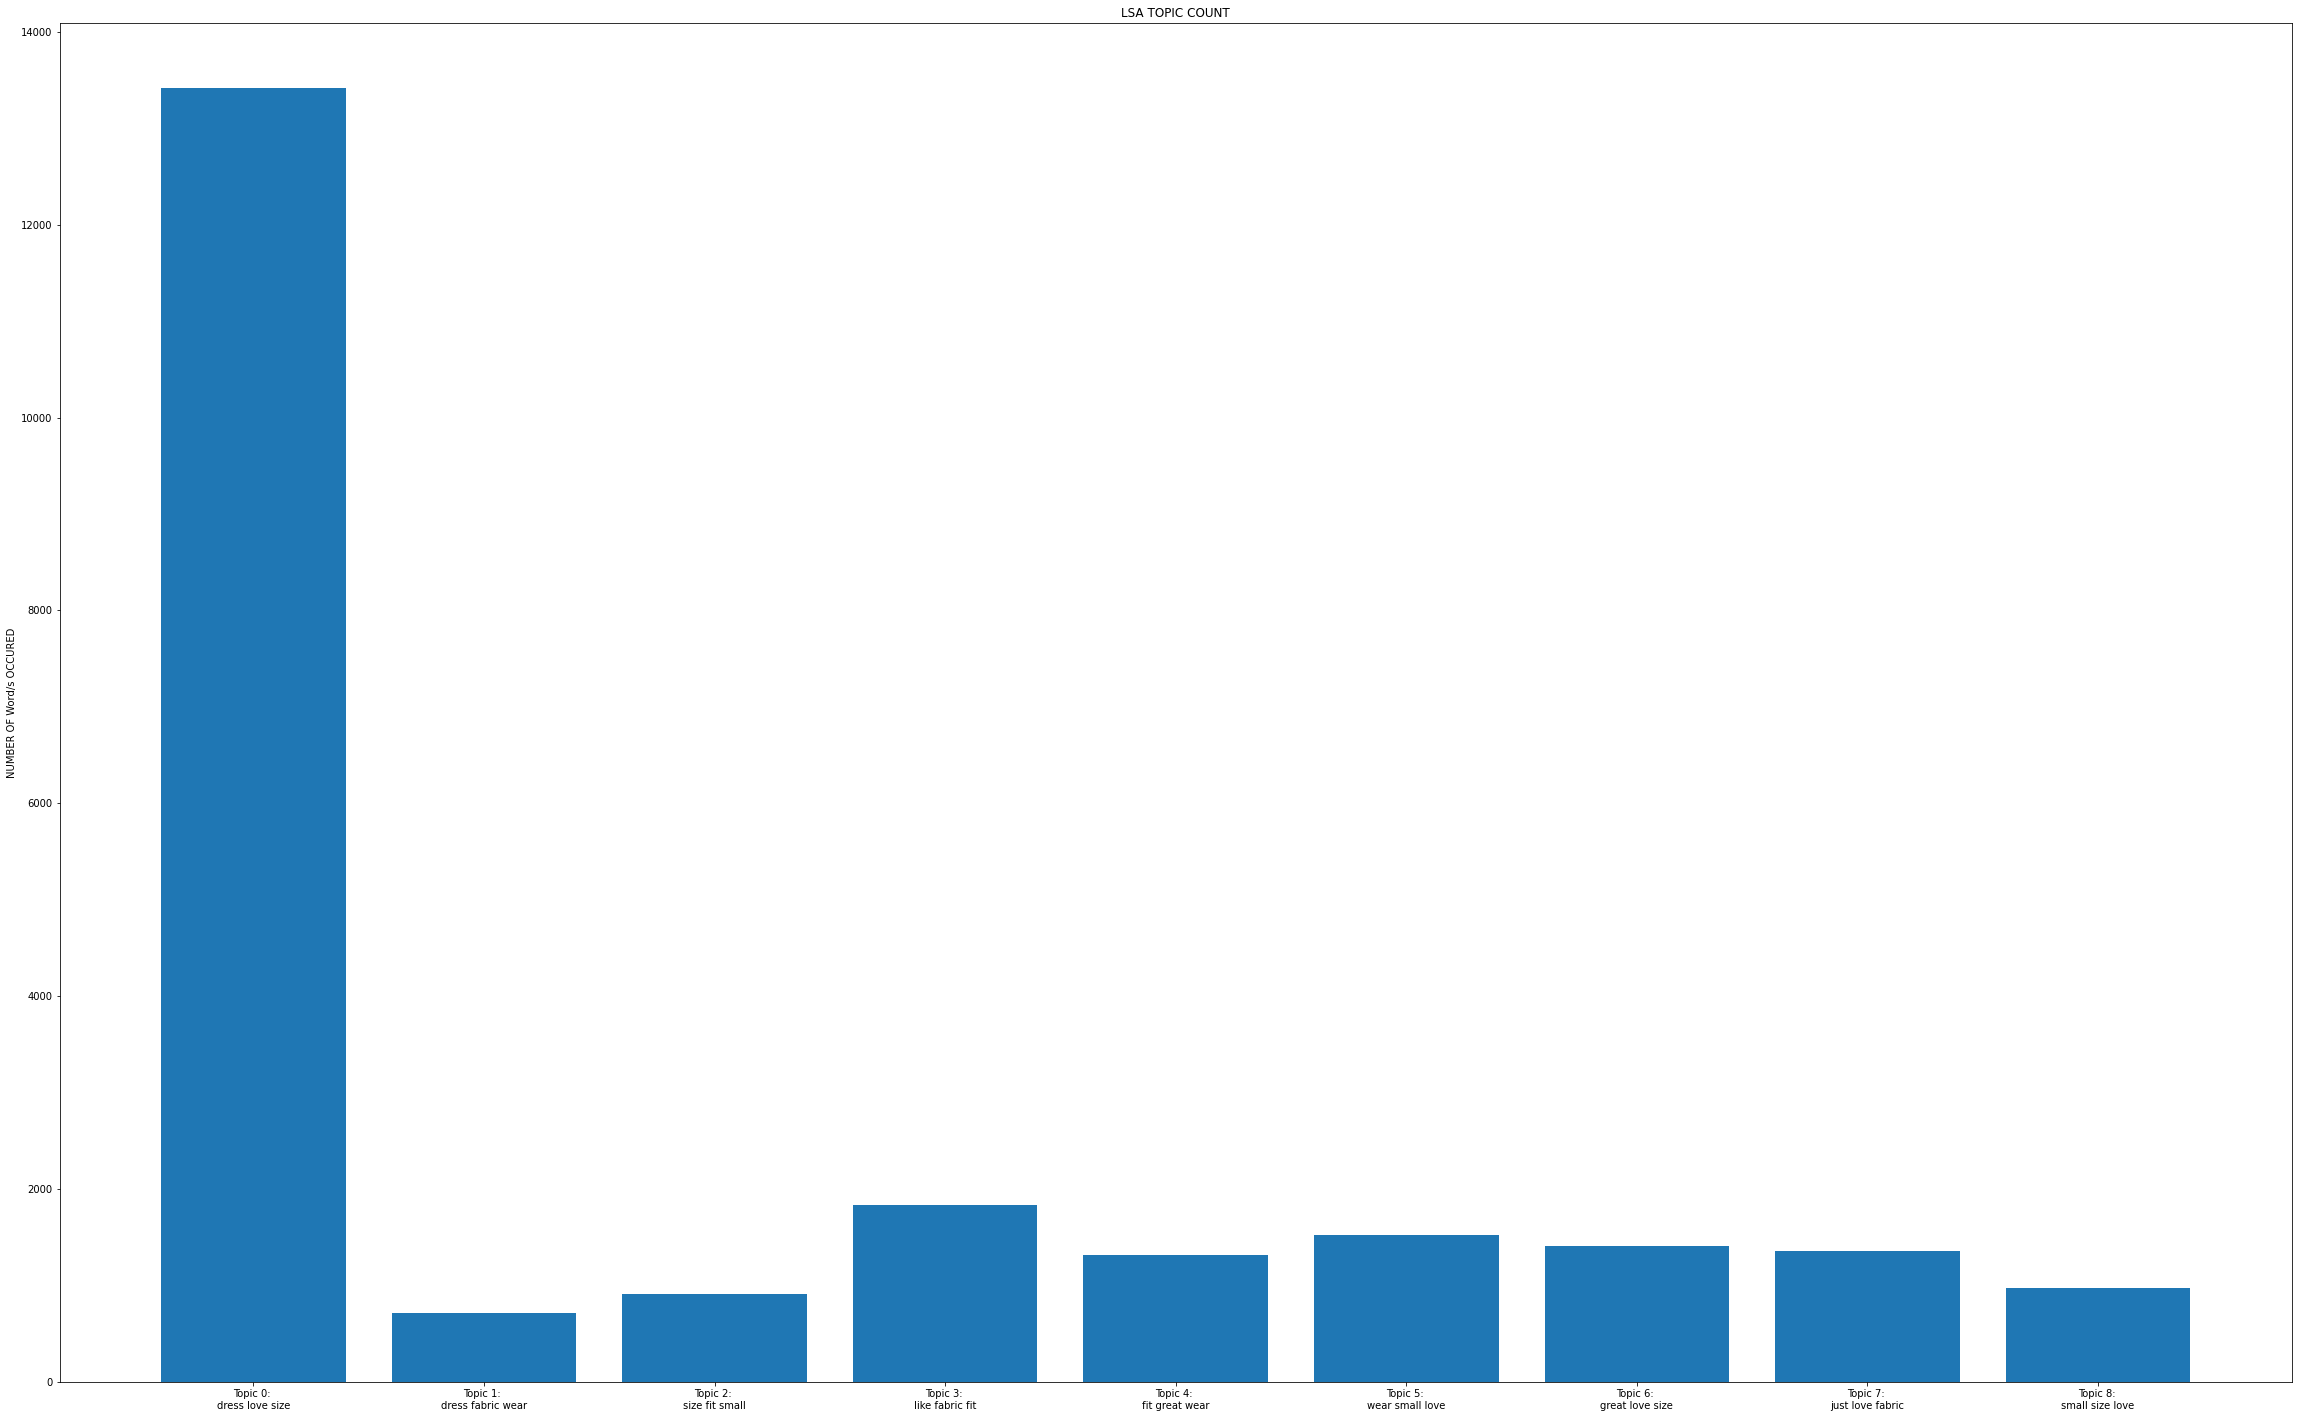

In [36]:
top3Words = collectTopnWords(3, LSAkeys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top3Words[i] for i in LSAcategories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(LSAcategories, lsa_counts);
ax.set_xticks(LSAcategories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF Word/s OCCURED');
ax.set_title('LSA TOPIC COUNT');
#plt.bar(color=['red'])
plt.show()

In [37]:
tsneLSAmodel = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=3000, verbose=1, random_state=0, angle=0.75)
tsneLSAvectors = tsneLSAmodel.fit_transform(lSATopicMatrix )


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 23486 samples in 0.101s...
[t-SNE] Computed neighbors for 23486 samples in 5.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23486
[t-SNE] Computed conditional probabilities for sample 2000 / 23486
[t-SNE] Computed conditional probabilities for sample 3000 / 23486
[t-SNE] Computed conditional probabilities for sample 4000 / 23486
[t-SNE] Computed conditional probabilities for sample 5000 / 23486
[t-SNE] Computed conditional probabilities for sample 6000 / 23486
[t-SNE] Computed conditional probabilities for sample 7000 / 23486
[t-SNE] Computed conditional probabilities for sample 8000 / 23486
[t-SNE] Computed conditional probabilities for sample 9000 / 23486
[t-SNE] Computed conditional probabilities for sample 10000 / 23486
[t-SNE] Computed conditional probabilities for sample 11000 / 23486
[t-SNE] Computed conditional probabilities for sample 12000 / 23486
[t-SNE] Computed conditional probabilities for sa

In [55]:
# Defining the helper functions
def collectTheMeanTopicVectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    collectTheMeanTopicVectors = []
    for t in range(numberOfTopics):
        topicArticles = []
        for i in range(len(keys)):
            if keys[i] == t:
                topicArticles.append(two_dim_vectors[i])    
        
        topicArticles = np.vstack(topicArticles)
        meanTopicArticles = np.mean(topicArticles, axis=0)
        collectTheMeanTopicVectors.append(meanTopicArticles)
    return collectTheMeanTopicVectors

In [51]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:numberOfTopics]

In [60]:
top3wordsLSA = collectTopnWords(3, LSAkeys, small_document_term_matrix, small_count_vectorizer)
LSAMeanTopicVectors = collectTheMeanTopicVectors(LSAkeys, tsneLSAvectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(numberOfTopics), plot_width=700, plot_height=700)
plot.scatter(x=tsneLSAvectors[:,0], y=tsneLSAvectors[:,1], color=colormap[LSAkeys])

for t in range(numberOfTopics):
    label = Label(x=LSAMeanTopicVectors[t][0], y=LSAMeanTopicVectors[t][1], 
                  text=top3wordsLSA[t], text_color=colormap[t])
    plot.add_layout(label)
    
plt.show(plot)

In [62]:
LDAmodel = LatentDirichletAllocation(n_components=numberOfTopics, learning_method='online', 
                                          random_state=0, verbose=0)
LDATopicMatrix = LDAmodel.fit_transform(small_document_term_matrix)

In [67]:
def collectLDAtopics(LDAmodel, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    featureNames = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(numberOfTopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = LDAmodel.components_[i].argsort()[:-20 - 1:-1]
        words = [featureNames[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [68]:
collectLDAtopics(LDAmodel, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,fit,just,dress,small,wear,size,like,love,great
1,fabric,love,fabric,size,love,fabric,fabric,fabric,love
2,love,size,love,fabric,fabric,fit,just,like,fabric
3,size,fabric,wear,love,size,like,wear,size,fit
4,like,fit,size,wear,fit,love,love,great,wear
5,just,like,like,fit,dress,wear,size,dress,size
6,wear,dress,fit,like,like,dress,fit,fit,dress
7,great,wear,just,just,great,just,dress,wear,like
8,dress,great,great,dress,small,great,great,just,just
9,small,small,small,great,just,small,small,small,small


In [76]:
LDAKeys =collectKeys(LDATopicMatrix)
LDAcategories, lda_counts = keys_to_counts(LDAKeys)

In [77]:
top_n_words_lda = collectTopnWords(15, LDAKeys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  fit size fabric love dress wear like just great small
Topic 2:  just love size fit dress like wear fabric great small
Topic 3:  dress size love fabric like fit wear just great small
Topic 4:  small size fit wear love like dress just fabric great
Topic 5:  wear love size dress fit great like just small fabric
Topic 6:  size love fit wear like dress fabric small just great
Topic 7:  like size fit just wear dress love fabric small great
Topic 8:  love fabric fit size dress like great wear just small
Topic 9:  great love fit size wear like dress just small fabric


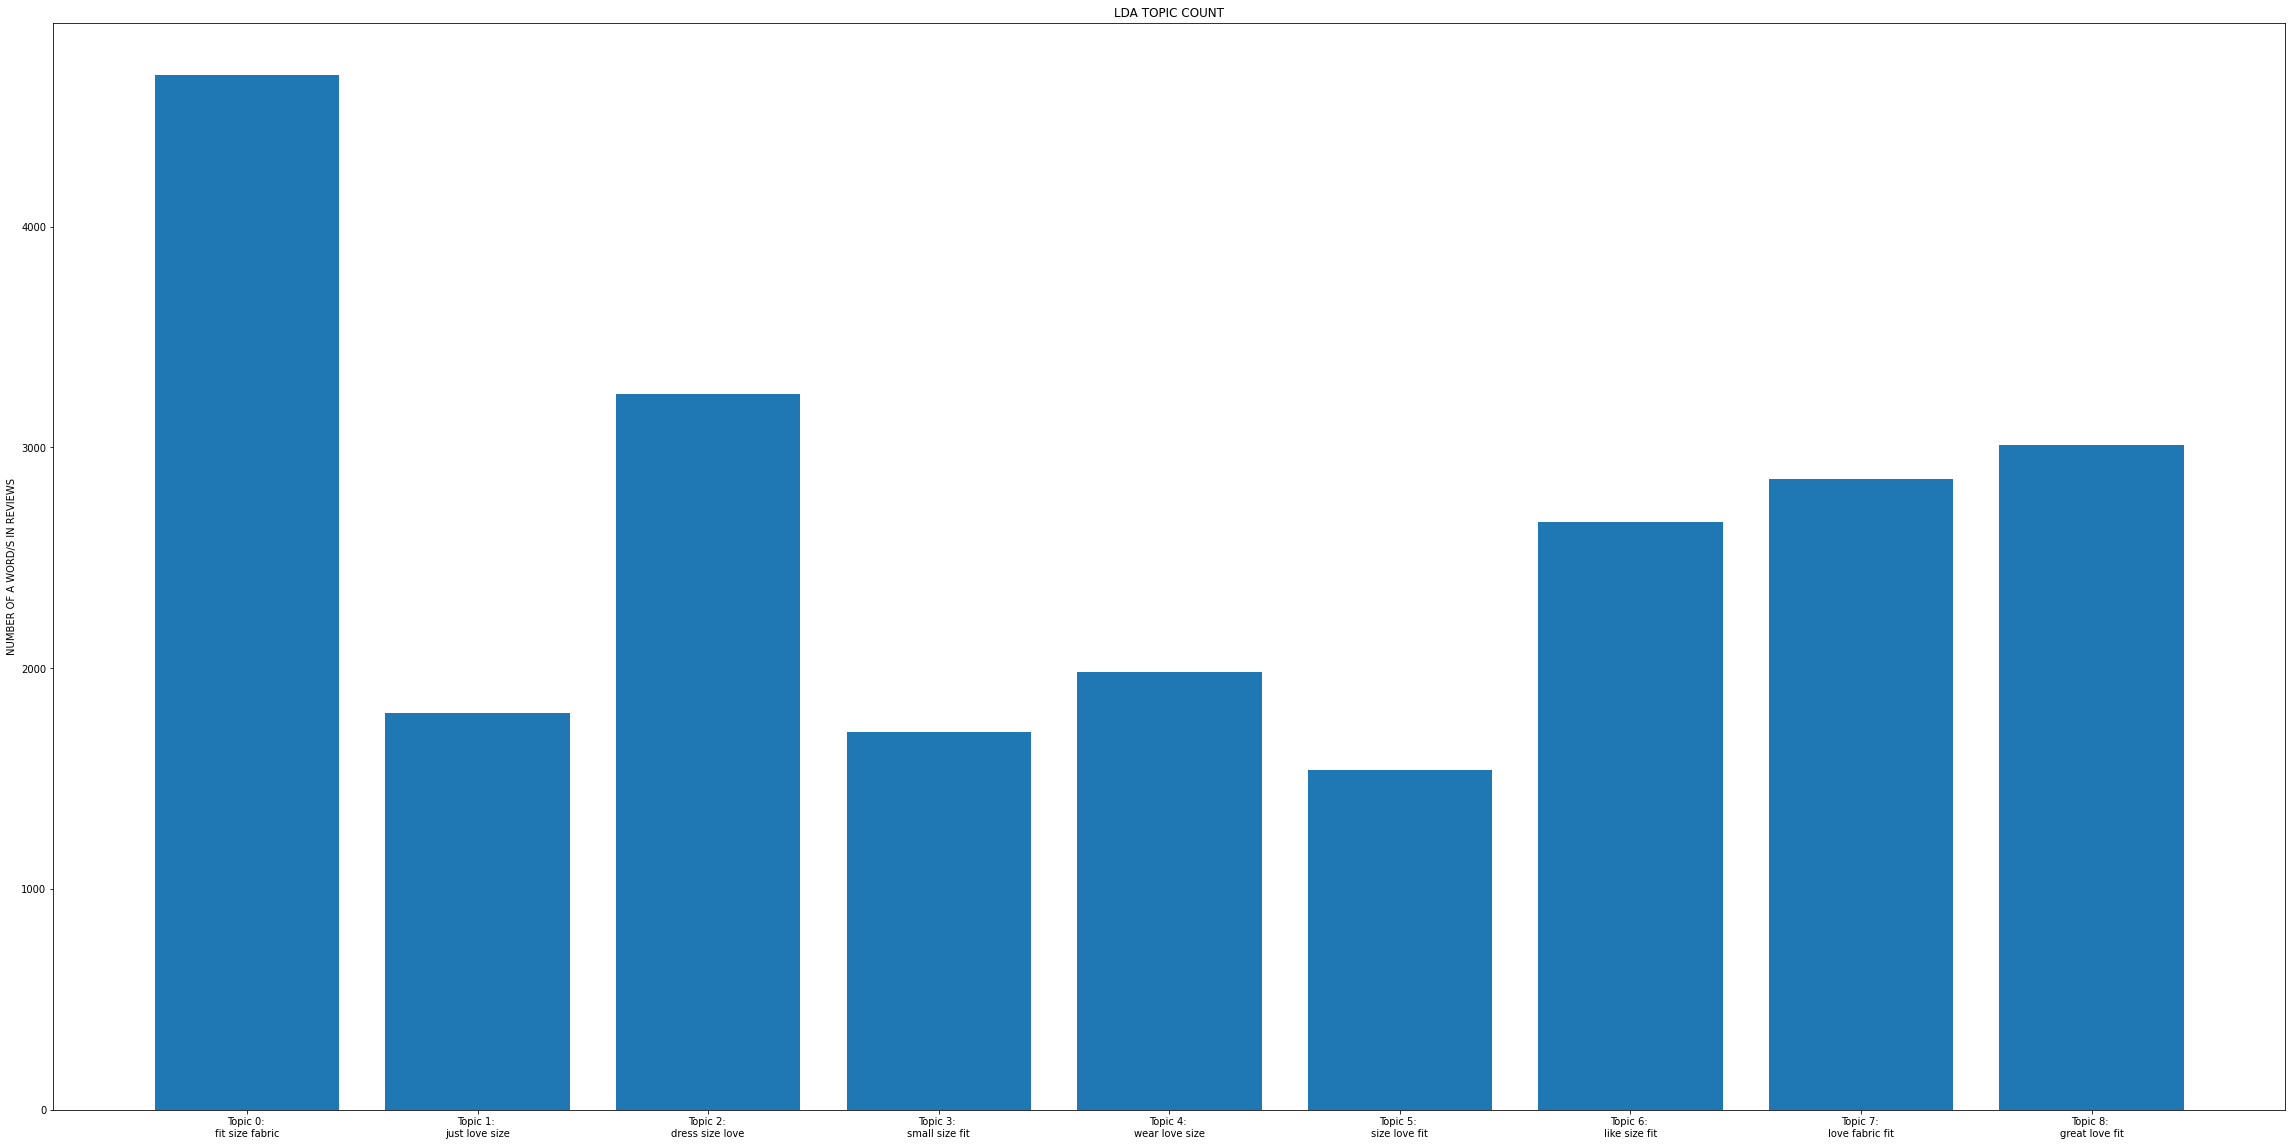

In [81]:
top3Words = collectTopnWords(3, LDAKeys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top3Words[i] for i in LDAcategories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(LDAcategories, lda_counts);
ax.set_xticks(LDAcategories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF A WORD/S IN REVIEWS');

In [80]:
tsnelLDAmodel = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsneLDAvectors = tsnelLDAmodel.fit_transform(LDATopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 23486 samples in 0.093s...
[t-SNE] Computed neighbors for 23486 samples in 4.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23486
[t-SNE] Computed conditional probabilities for sample 2000 / 23486
[t-SNE] Computed conditional probabilities for sample 3000 / 23486
[t-SNE] Computed conditional probabilities for sample 4000 / 23486
[t-SNE] Computed conditional probabilities for sample 5000 / 23486
[t-SNE] Computed conditional probabilities for sample 6000 / 23486
[t-SNE] Computed conditional probabilities for sample 7000 / 23486
[t-SNE] Computed conditional probabilities for sample 8000 / 23486
[t-SNE] Computed conditional probabilities for sample 9000 / 23486
[t-SNE] Computed conditional probabilities for sample 10000 / 23486
[t-SNE] Computed conditional probabilities for sample 11000 / 23486
[t-SNE] Computed conditional probabilities for sample 12000 / 23486
[t-SNE] Computed conditional probabilities for sa

In [83]:
top3WordsLDA = collectTopnWords(3, LDAKeys, small_document_term_matrix, small_count_vectorizer)
LDAMeanTopicVectors = collectTheMeanTopicVectors(LDAKeys, tsneLDAvectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(numberOfTopics), plot_width=900, plot_height=900)
plot.scatter(x=tsneLDAvectors[:,0], y=tsneLDAvectors[:,1], color=colormap[LDAKeys])

for t in range(numberOfTopics):
    label = Label(x=LSAMeanTopicVectors[t][0], y=LSAMeanTopicVectors[t][1], 
                  text=top3WordsLDA[t], text_color=colormap[t])
    plot.add_layout(label)

plt.show(plot)

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [85]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(small_document_term_matrix);

In [86]:

xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [91]:

#obtain a NMF model.
model = NMF(n_components=numberOfTopics, init='nndsvd');
#fit the model
nnfTMatrix = model.fit_transform(xtfidf_norm)
nnfTMatrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02904029, 0.09145951, 0.        , ..., 0.        , 0.05269627,
        0.        ],
       [0.0153507 , 0.00039416, 0.03258509, ..., 0.03066458, 0.03112069,
        0.00349801],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05882824, 0.        ,
        0.06962534],
       [0.04468622, 0.        , 0.        , ..., 0.0369203 , 0.04035827,
        0.        ],
       [0.05602123, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [89]:
def collectNMFTopics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    featureNames = small_count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(numberOfTopics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        wordsIDs = model.components_[i].argsort()[:-20 - 1:-1]
        words = [featureNames[key] for key in wordsIDs]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [90]:
collectNMFTopics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,dress,love,size,great,like,wear,fit,just,fabric
1,small,small,small,small,small,small,small,small,small
2,wear,wear,wear,wear,wear,size,wear,wear,wear
3,size,size,love,size,size,love,size,size,size
4,love,like,like,love,love,like,love,love,love
5,like,just,just,like,just,just,like,like,like
6,just,great,great,just,great,great,just,great,just
7,great,fit,fit,fit,fit,fit,great,fit,great
8,fit,fabric,fabric,fabric,fabric,fabric,fabric,fabric,fit
9,fabric,dress,dress,dress,dress,dress,dress,dress,dress


In [92]:
nnfKEYS = collectKeys(nnfTMatrix)
nnfCategories, nnfCOUNTS = keys_to_counts(nnfKEYS)

In [100]:

nTopWords_nnf = collectTopnWords(15, nnfKEYS, small_document_term_matrix, small_count_vectorizer)

for i in range(len(nTopWords_nnf)):
    print("Topic {}: ".format(i+1), nTopWords_nnf[i])

Topic 1:  dress size love like fit wear just fabric great small
Topic 2:  love dress size small great wear fit like just fabric
Topic 3:  size small dress fit love wear like just fabric great
Topic 4:  great love fit size wear dress like small just fabric
Topic 5:  like size love dress fit wear small great just fabric
Topic 6:  wear small love size dress fit like great just fabric
Topic 7:  fit size small love dress like great just wear fabric
Topic 8:  just love like fit size dress wear great small fabric
Topic 9:  fabric love like dress fit size great wear just small


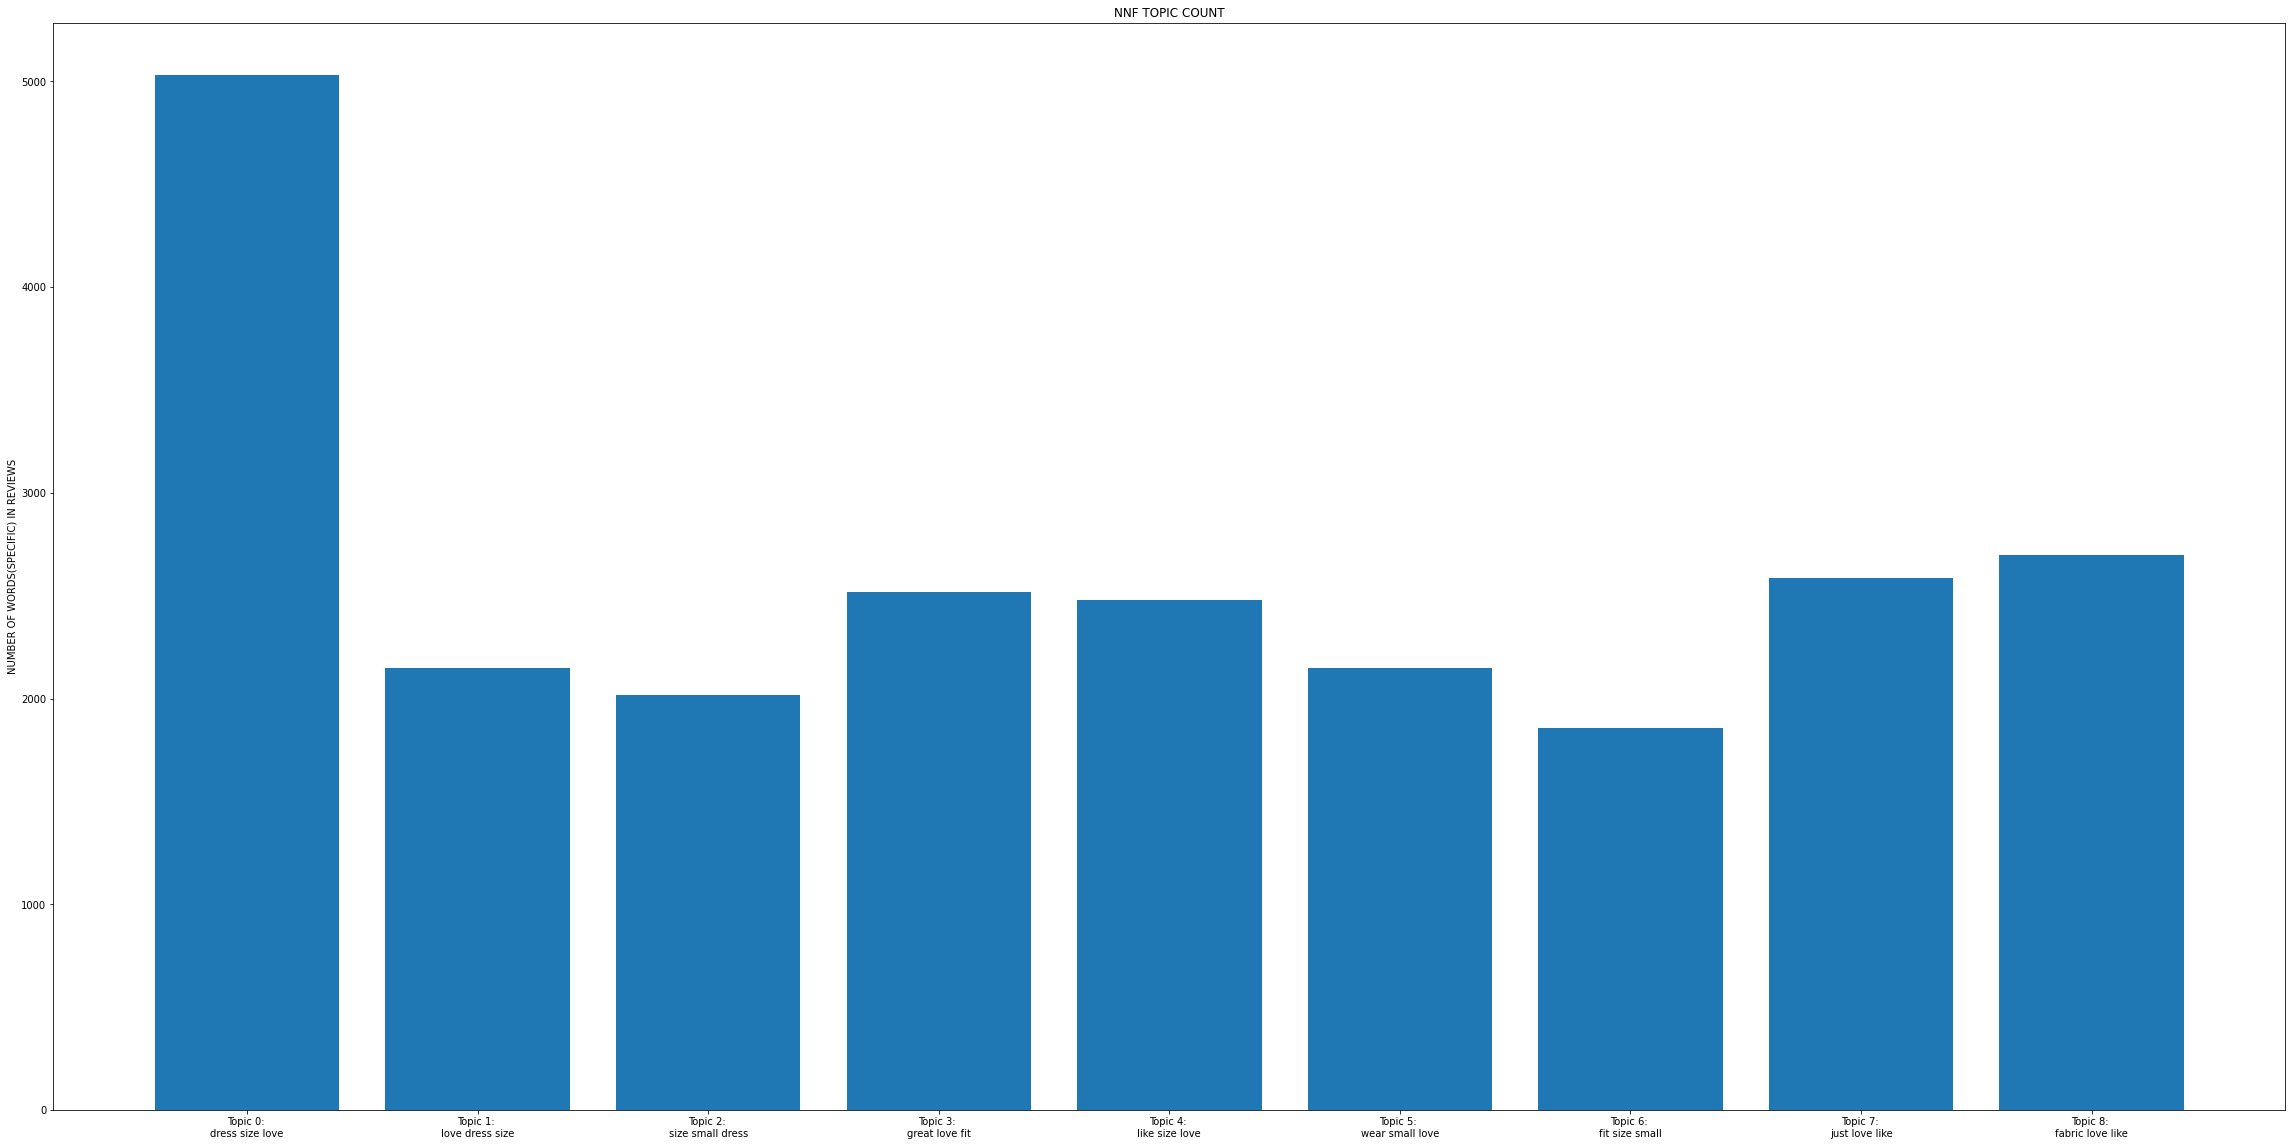

In [170]:
top_3_words = collectTopnWords(3, nnfKEYS, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in nnfCategories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(nnfCategories, nnfCOUNTS);
ax.set_xticks(nnfCategories);
ax.set_xticklabels(labels);
ax.set_title('NNF TOPIC COUNT');
ax.set_ylabel('NUMBER OF WORDS(SPECIFIC) IN REVIEWS');

In [104]:
tsneNNFmodel = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsneNNFvectors = tsneNNFmodel.fit_transform(nnfTMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 23486 samples in 0.479s...
[t-SNE] Computed neighbors for 23486 samples in 9.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23486
[t-SNE] Computed conditional probabilities for sample 2000 / 23486
[t-SNE] Computed conditional probabilities for sample 3000 / 23486
[t-SNE] Computed conditional probabilities for sample 4000 / 23486
[t-SNE] Computed conditional probabilities for sample 5000 / 23486
[t-SNE] Computed conditional probabilities for sample 6000 / 23486
[t-SNE] Computed conditional probabilities for sample 7000 / 23486
[t-SNE] Computed conditional probabilities for sample 8000 / 23486
[t-SNE] Computed conditional probabilities for sample 9000 / 23486
[t-SNE] Computed conditional probabilities for sample 10000 / 23486
[t-SNE] Computed conditional probabilities for sample 11000 / 23486
[t-SNE] Computed conditional probabilities for sample 12000 / 23486
[t-SNE] Computed conditional probabilities for sa

In [123]:
top3wordsNNF = collectTopnWords(3,  nnfKEYS, small_document_term_matrix, small_count_vectorizer)
nnfMeanTopicVectors = collectTheMeanTopicVectors(nnfKEYS, tsneNNFvectors)

plot = figure(title="t-SNE CLUSTERING OF {} NNF TOPICS".format(numberOfTopics), plot_width=900, plot_height=900)
plot.scatter(x=tsneNNFvectors[:,0], y=tsneNNFvectors[:,1], color=colormap[nnfKEYS])

for t in range(numberOfTopics):
    label = Label(x=nnfMeanTopicVectors[t][0], y=nnfMeanTopicVectors[t][1], 
                  text=top3wordsNNF[t], text_color=colormap[t])
    plot.add_layout(label)

plt.show(plot)

In [116]:
plt.show()

In [108]:
big_sample_size = 30

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=10)
big_text_sample = datafText.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=numberOfTopics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);

In [125]:
# Preparing a corpus for analysis and checking the first 10 entries
corpus=[]

corpus = dataf['Review Text'].to_list()

corpus[:10]


['Absolutely wonderful - silky and sexy and comfortable',
 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [126]:
corpus = list(set(corpus))
corpus[:10]

[nan,
 "I stopped into a store near me specifically to try these on given how adorable they look here. while i liked them, i didn't love them. i love some stretch, so that part was good. however, the denim was much thinner and lighter colored than they look to me online here. \r\n\r\n\r\ni really want to love them, though their light color has me less enthusiastic. another reviewer also mentioned a butt-flattening effect, which i noticed also. i might have sprung for them anyway, they do have a cute shape, bu",
 'I fell in love with these online. i thought they would be such a nice piece of statement denim. unfortunately they did not work for me. i am 5\'2" and the waist of these paints was four inches away from my breasts. it didn\'t look bad from the back but from the front it was comical. the denim itself is nice and heavy but, like the previous reviewer stated, not a dark wash. the pair i received was a medium whiskered wash. if i was taller these would have been a yes, despite the

In [127]:
print('There is '+str(len(corpus))+' unique question')

There is 22635 unique question


In [146]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\LEONFR~1\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [148]:
# removing common words and tokenizing
import os
import nltk
nltk.download('stopwords')
from string import punctuation
stoplist = stopwords.words('english') + list(punctuation) + list("([)]?") + [")?"]

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'TF2.0_QA.dict'))  # store the dictio

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LeonFremz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2021-05-03 14:40:01,801 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-03 14:40:02,965 : INFO : adding document #10000 to Dictionary(23530 unique tokens: ['nan', 'adorable', 'also', 'also.', 'another']...)
2021-05-03 14:40:04,253 : INFO : adding document #20000 to Dictionary(34878 unique tokens: ['nan', 'adorable', 'also', 'also.', 'another']...)
2021-05-03 14:40:04,400 : INFO : built Dictionary(37543 unique tokens: ['nan', 'adorable', 'also', 'also.', 'another']...) from 22635 documents (total 684875 corpus positions)
2021-05-03 14:40:04,401 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(37543 unique tokens: ['nan', 'adorable', 'also', 'also.', 'another']...) from 22635 documents (total 684875 corpus positions)", 'datetime': '2021-05-03T14:40:04.401106', 'gensim': '4.0.1', 'python': '3

In [149]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'TF2.0_QA.mm'), corpus)

2021-05-03 14:40:15,999 : INFO : storing corpus in Matrix Market format to C:\Users\LEONFR~1\AppData\Local\Temp\TF2.0_QA.mm
2021-05-03 14:40:16,002 : INFO : saving sparse matrix to C:\Users\LEONFR~1\AppData\Local\Temp\TF2.0_QA.mm
2021-05-03 14:40:16,004 : INFO : PROGRESS: saving document #0
2021-05-03 14:40:16,070 : INFO : PROGRESS: saving document #1000
2021-05-03 14:40:16,149 : INFO : PROGRESS: saving document #2000
2021-05-03 14:40:16,203 : INFO : PROGRESS: saving document #3000
2021-05-03 14:40:16,255 : INFO : PROGRESS: saving document #4000
2021-05-03 14:40:16,306 : INFO : PROGRESS: saving document #5000
2021-05-03 14:40:16,356 : INFO : PROGRESS: saving document #6000
2021-05-03 14:40:16,447 : INFO : PROGRESS: saving document #7000
2021-05-03 14:40:16,555 : INFO : PROGRESS: saving document #8000
2021-05-03 14:40:16,665 : INFO : PROGRESS: saving document #9000
2021-05-03 14:40:16,772 : INFO : PROGRESS: saving document #10000
2021-05-03 14:40:16,890 : INFO : PROGRESS: saving documen

In [151]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2021-05-03 14:43:19,617 : INFO : collecting document frequencies
2021-05-03 14:43:19,630 : INFO : PROGRESS: processing document #0
2021-05-03 14:43:19,976 : INFO : PROGRESS: processing document #10000
2021-05-03 14:43:20,126 : INFO : PROGRESS: processing document #20000
2021-05-03 14:43:20,297 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 22635 documents and 37543 features (647041 matrix non-zeros)', 'datetime': '2021-05-03T14:43:20.296666', 'gensim': '4.0.1', 'python': '3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'initialize'}


In [152]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors


In [153]:
total_topics = 15

In [154]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf


2021-05-03 14:44:12,288 : INFO : using symmetric alpha at 0.06666666666666667
2021-05-03 14:44:12,296 : INFO : using symmetric eta at 0.06666666666666667
2021-05-03 14:44:12,314 : INFO : using serial LDA version on this node
2021-05-03 14:44:12,430 : INFO : running online (single-pass) LDA training, 15 topics, 1 passes over the supplied corpus of 22635 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-03 14:44:12,445 : INFO : PROGRESS: pass 0, at document #2000/22635
2021-05-03 14:44:16,292 : INFO : merging changes from 2000 documents into a model of 22635 documents
2021-05-03 14:44:16,391 : INFO : topic #0 (0.067): 0.012*"like" + 0.010*"i'm" + 0.009*"little" + 0.008*"wear" + 0.008*"would" + 0.007*"ordered" + 0.007*"love" + 0.006*"really" + 0.006*"size" + 0.006*"it."
2021-05-03 14:44:16,395 : INFO : topic #13 (0.067): 0.019*"love" + 0.016*"size" + 0.011*"top" + 0.011*"great" +

2021-05-03 14:44:32,482 : INFO : merging changes from 2000 documents into a model of 22635 documents
2021-05-03 14:44:32,530 : INFO : topic #0 (0.067): 0.017*"like" + 0.014*"would" + 0.009*"i'm" + 0.009*"little" + 0.009*"ordered" + 0.009*"really" + 0.008*"look" + 0.008*"xs" + 0.007*"think" + 0.007*"it."
2021-05-03 14:44:32,532 : INFO : topic #14 (0.067): 0.024*"size" + 0.016*"fit" + 0.013*"pants" + 0.011*"i'm" + 0.010*"wear" + 0.010*"one" + 0.009*"i've" + 0.008*"ordered" + 0.008*"usually" + 0.006*"size."
2021-05-03 14:44:32,536 : INFO : topic #4 (0.067): 0.015*"like" + 0.015*"great" + 0.011*"love" + 0.011*"really" + 0.010*"top" + 0.009*"color" + 0.009*"i'm" + 0.009*"looks" + 0.009*"fit" + 0.008*"material"
2021-05-03 14:44:32,538 : INFO : topic #1 (0.067): 0.037*"love" + 0.017*"wear" + 0.013*"great" + 0.011*"i'm" + 0.011*"medium" + 0.010*"perfect" + 0.010*"little" + 0.009*"top" + 0.009*"small" + 0.008*"soft"
2021-05-03 14:44:32,541 : INFO : topic #9 (0.067): 0.019*"dress" + 0.014*"like"

In [155]:
lda.show_topics(total_topics,5)

[(0,
  '0.016*"like" + 0.015*"would" + 0.010*"really" + 0.010*"little" + 0.009*"ordered"'),
 (1,
  '0.038*"love" + 0.020*"wear" + 0.015*"great" + 0.014*"medium" + 0.012*"i\'m"'),
 (2,
  '0.017*"small" + 0.014*"xs" + 0.010*"ordered" + 0.009*"i\'m" + 0.009*"size"'),
 (3,
  '0.019*"sweater" + 0.015*"color" + 0.010*"great" + 0.010*"like" + 0.009*"nice"'),
 (4,
  '0.016*"like" + 0.015*"great" + 0.012*"love" + 0.012*"color" + 0.010*"looks"'),
 (5,
  '0.011*"slits" + 0.011*"print," + 0.009*"size)" + 0.008*"(my" + 0.008*"pricey"'),
 (6, '0.028*"size" + 0.023*"i\'m" + 0.017*"fit" + 0.012*"petite" + 0.010*"4"'),
 (7,
  '0.060*"dress" + 0.012*"love" + 0.008*"perfect" + 0.008*"would" + 0.008*"look"'),
 (8,
  '0.028*"dress" + 0.017*"size" + 0.016*"like" + 0.015*"fit" + 0.013*"would"'),
 (9,
  '0.015*"dress" + 0.012*"like" + 0.011*"wear" + 0.011*"fit" + 0.010*"perfect"'),
 (10, '0.014*"saw" + 0.014*"it." + 0.013*"love" + 0.012*"one" + 0.012*"like"'),
 (11,
  '0.025*"love" + 0.021*"wore" + 0.020*"gre

In [160]:
df_lda = pd.read_csv('C:\\Users\\LeonFremz\\Modelling and Optimisation\\Womens Clothing E-Commerce Reviews.csv')
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(11, 23486)


In [161]:
df_lda

,0,1,2,3,4,5,6,7,8,9,...,23476,23477,23478,23479,23480,23481,23482,23483,23484,23485
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,23476,23477,23478,23479,23480,23481,23482,23483,23484,23485
Clothing ID,767,1080,1077,1049,847,1080,858,858,1077,1077,...,522,1094,1104,1005,862,1104,862,1104,1084,1104
Age,33,34,60,50,47,49,39,39,24,34,...,27,39,32,42,35,34,48,31,28,52
Title,0,0,Some major design flaws,My favorite buy!,Flattering shirt,Not for the very petite,Cagrcoal shimmer fun,"Shimmer, surprisingly goes with lots",Flattering,Such a fun dress!,...,Cheeky!,Entrancing,Unflattering,What a fun piece!,0,Great dress for many occasions,Wish it was made of cotton,"Cute, but see through","Very cute dress, perfect for summer parties an...",Please make more like this one!
Review Text,Absolutely wonderful - silky and sexy and comf...,Love this dress! it's sooo pretty. i happene...,I had such high hopes for this dress and reall...,"I love, love, love this jumpsuit. it's fun, fl...",This shirt is very flattering to all due to th...,"I love tracy reese dresses, but this one is no...",I aded this in my basket at hte last mintue to...,"I ordered this in carbon for store pick up, an...",I love this dress. i usually get an xs but it ...,"I'm 5""5' and 125 lbs. i ordered the s petite t...",...,These bottoms are very cute but defiantly chee...,I'm so impressed with the beautiful color comb...,I was surprised at the positive reviews for th...,So i wasn't sure about ordering this skirt bec...,0,I was very happy to snag this dress at such a ...,"It reminds me of maternity clothes. soft, stre...","This fit well, but the top was very see throug...",I bought this dress for a wedding i have this ...,This dress in a lovely platinum is feminine an...
Rating,4,5,3,5,5,2,5,4,5,5,...,4,4,1,5,5,5,3,3,3,5
Recommended IND,1,1,0,1,1,0,1,1,1,1,...,1,1,0,1,1,1,1,0,1,1
Positive Feedback Count,0,4,0,0,6,4,1,4,0,0,...,0,5,0,0,0,0,0,1,2,22
Division Name,Initmates,General,General,General Petite,General,General,General Petite,General Petite,General,General,...,Initmates,General Petite,General Petite,General Petite,General Petite,General Petite,General Petite,General Petite,General,General Petite
Department Name,Intimate,Dresses,Dresses,Bottoms,Tops,Dresses,Tops,Tops,Dresses,Dresses,...,Intimate,Dresses,Dresses,Bottoms,Tops,Dresses,Tops,Dresses,Dresses,Dresses


C:\Users\LeonFremz\AppData\Roaming\Python\Python36\site-packages\seaborn\matrix.py:620: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



ValueError: The number of observations cannot be determined on an empty distance matrix.

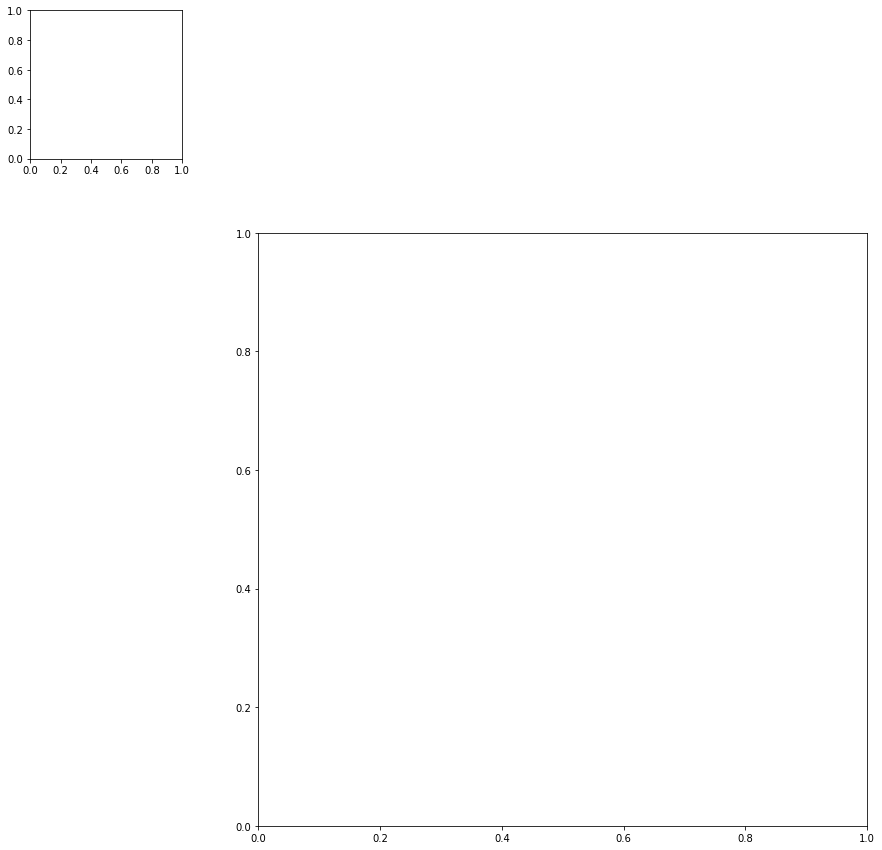

In [167]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
